In [1]:
library("dplyr")
library("Seurat")
library("patchwork")
library("ggplot2")
library("clustree")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘Seurat’ was built under R version 4.5.2”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.5.2”
Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘ggplot2’ was built under R version 4.5.2”
Loading required package: ggraph


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry




In [36]:
day0_5.data = Read10X(data.dir = "../Day0_5/filtered_feature_bc_matrix/")

day0_5_Seurat1 = CreateSeuratObject(counts = day5.data, project = "Day0_5", min.cells = 3, min.features = 2000)
print(day0_5_Seurat1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
18029 features across 1101 samples within 1 assay 
Active assay: RNA (18029 features, 0 variable features)
 1 layer present: counts


In [37]:
head(day0_5_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCACAAGTACCT-1,Day0_5,5105,2192
AAACGCTCAAGTCCAT-1,Day0_5,5344,2250
AAACGCTGTTCATCGA-1,Day0_5,6407,2876
AAAGAACAGTGAACAT-1,Day0_5,6469,2016
AAAGGATGTCACCCTT-1,Day0_5,5983,2446
AAAGGGCGTATCCCTC-1,Day0_5,5785,2214
AAAGGGCGTTGGCTAT-1,Day0_5,7224,2314
AAAGTCCCACTCAGAT-1,Day0_5,5588,2457
AAAGTGAAGATTGACA-1,Day0_5,5074,2085


### Add the percent of mitochondrial genes

In [38]:
# NOTE: only works when using LOWERCASE mt
day0_5_Seurat1[["percent.mt"]] = PercentageFeatureSet(day5_Seurat1, pattern = "^mt-")
head(day0_5_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCACAAGTACCT-1,Day0_5,5105,2192,2.076396
AAACGCTCAAGTCCAT-1,Day0_5,5344,2250,2.002246
AAACGCTGTTCATCGA-1,Day0_5,6407,2876,1.389106
AAAGAACAGTGAACAT-1,Day0_5,6469,2016,2.581543
AAAGGATGTCACCCTT-1,Day0_5,5983,2446,1.838543
AAAGGGCGTATCCCTC-1,Day0_5,5785,2214,1.953328
AAAGGGCGTTGGCTAT-1,Day0_5,7224,2314,3.114618
AAAGTCCCACTCAGAT-1,Day0_5,5588,2457,3.382248
AAAGTGAAGATTGACA-1,Day0_5,5074,2085,2.404415


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


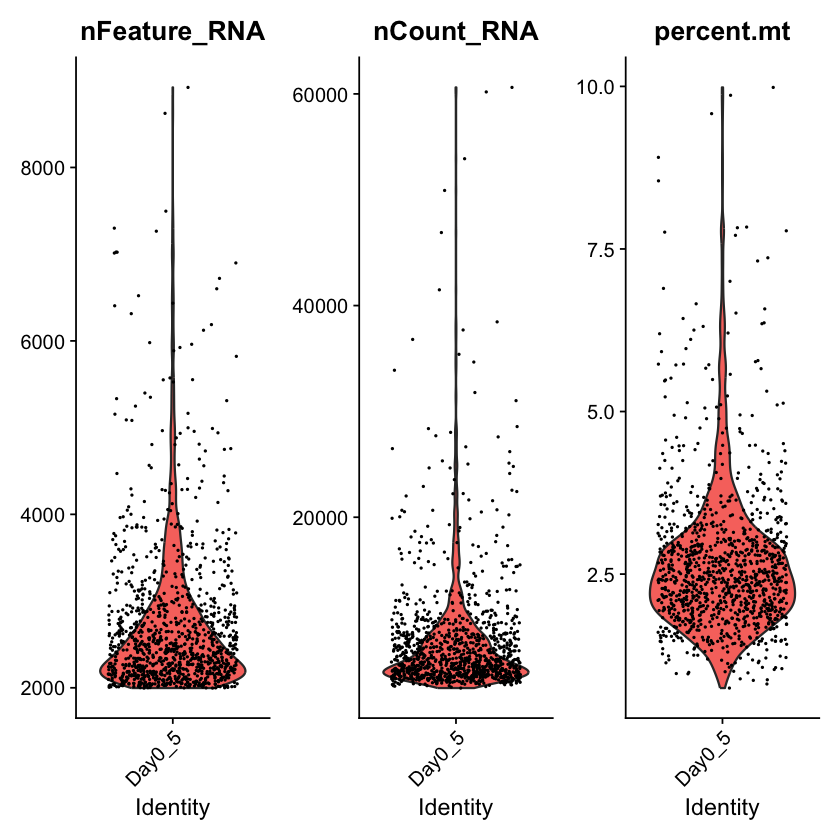

In [39]:
# Visualize QC metrics as a violin plot
# Start here to see the general trend of RNA and Counts
Vln_plots1 = VlnPlot(day0_5_Seurat1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(Vln_plots1)

In [40]:
pdf(file = "../Day0_5/figures/Day0_5_violin_plots.pdf",
    width = 10,
    height = 10)
print(Vln_plots1)
dev.off()

agg_record_692476646 
                   2

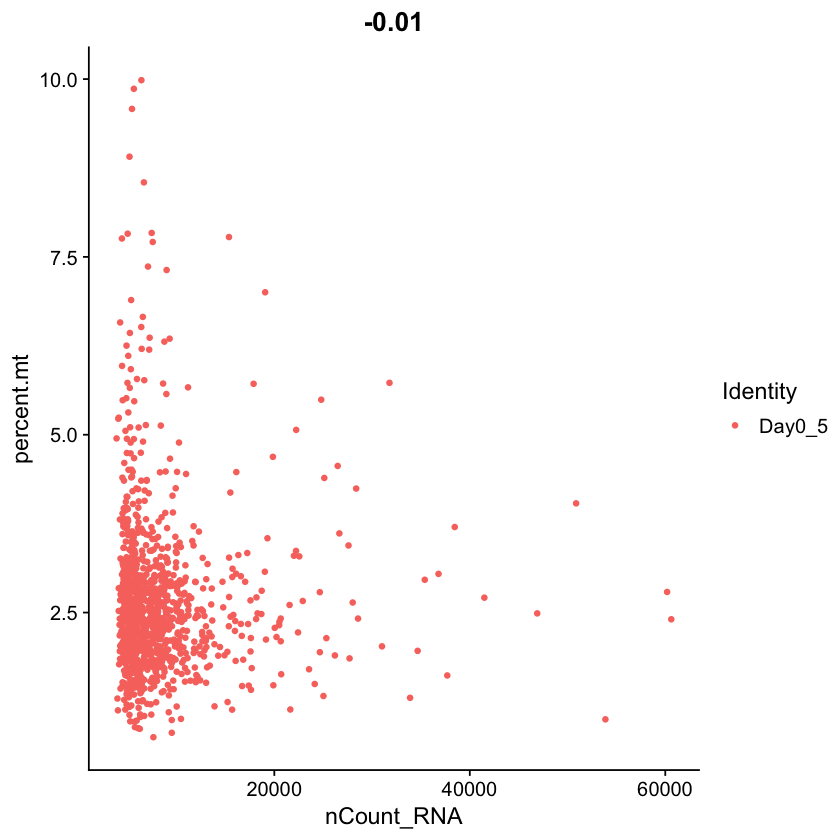

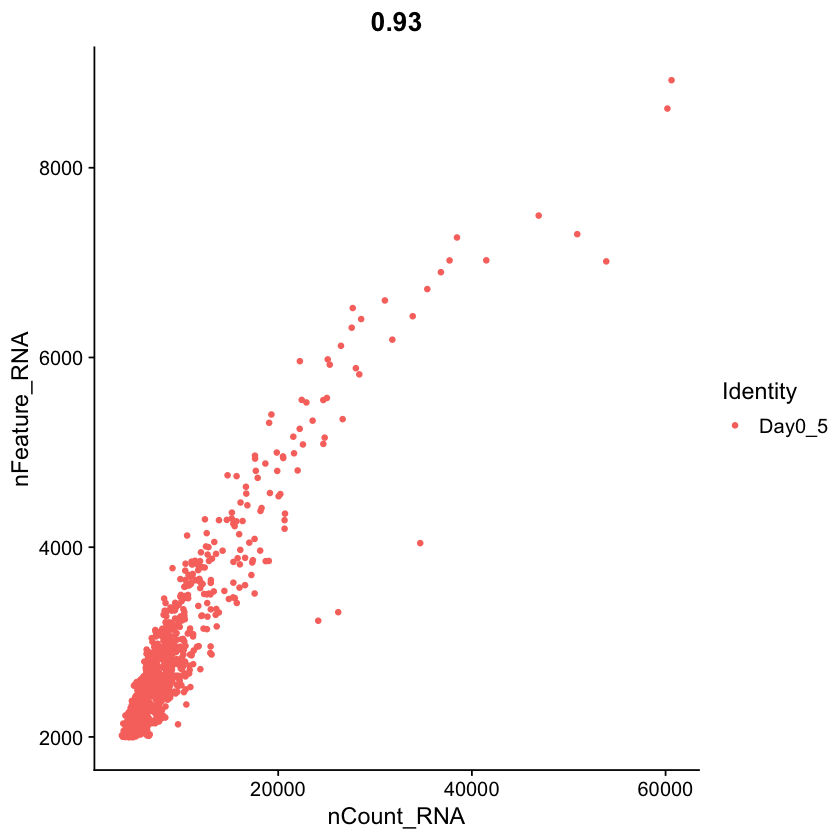

In [44]:
# FeatureScatter is typically used to visualize feature-feature 
# relationships, but can be used for anything calculated by the 
# object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(day0_5_Seurat1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(day0_5_Seurat1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
print(plot1)
print(plot2)

In [71]:
# Gather cells samples that have more than 200 genes and less than 5,000. 
# Anything less is most likely empty, anything higher than 5,000 most 
# likely contains more than one cell.
# Remove any cells that have more than 10 percent mitochondrial 
# counts as these are likely artifacts. Cell membrane is compromised 
# or mRNA leakage where only the mitochondrial mRNA remains
day0_5_Seurat2 <- subset(day0_5_Seurat1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)

### Normalize the data

In [72]:
day0_5_Seurat3 = NormalizeData(object = day0_5_Seurat2, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



### Identification of highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


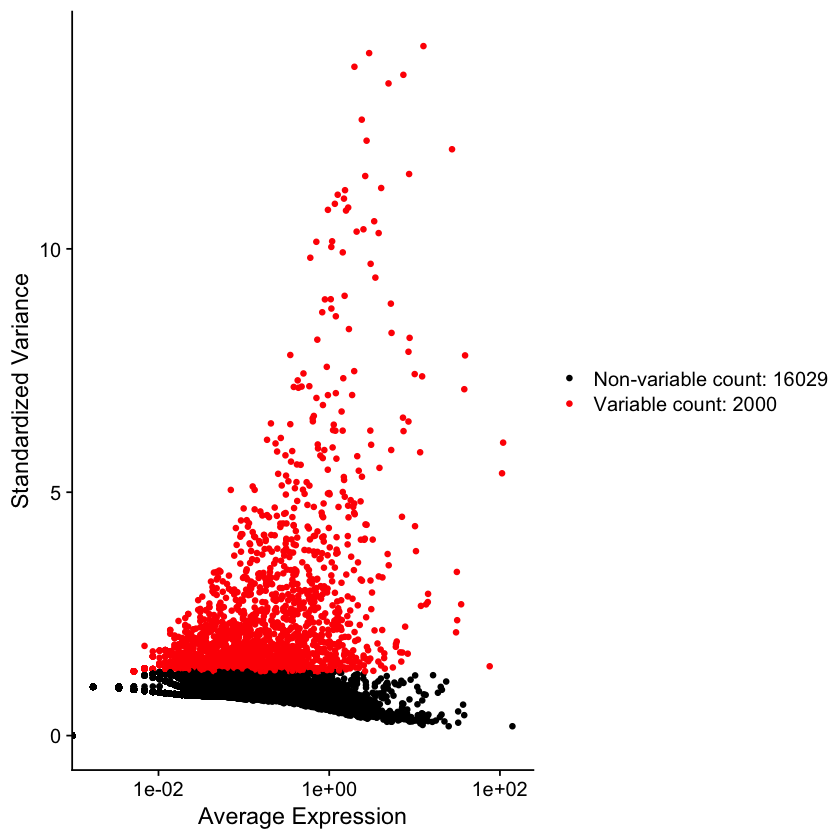

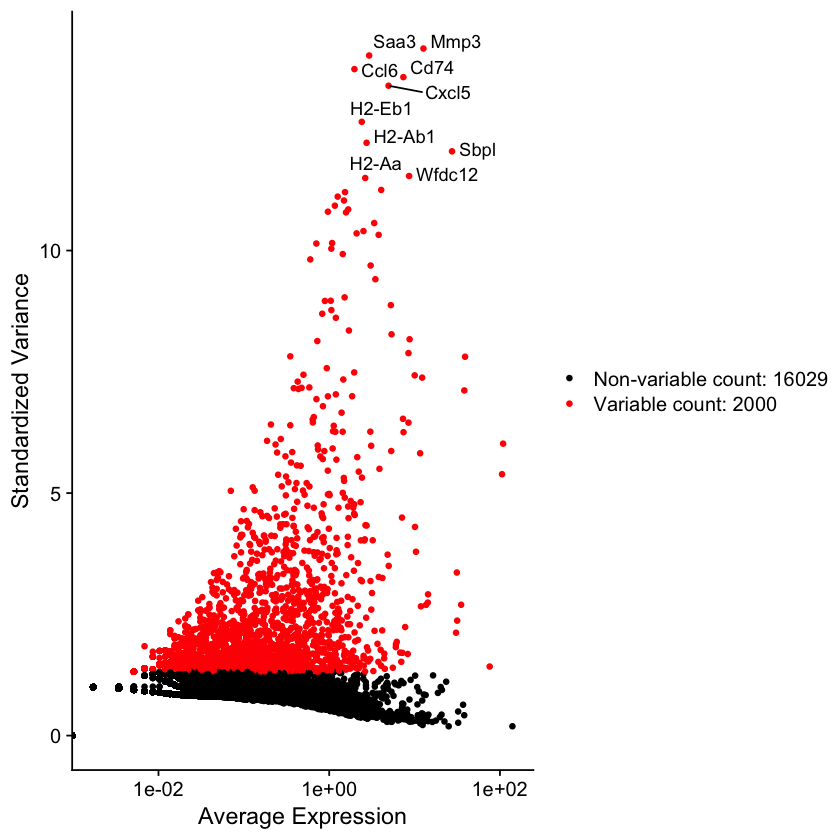

In [73]:
day0_5_Seurat3 = FindVariableFeatures(day0_5_Seurat3, selection.method = "vst", nfeatures = 2000)

#plot the top 10 features
top10 = head(VariableFeatures(day0_5_Seurat3),10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(day0_5_Seurat3)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

In [48]:
pdf(file = "../Day0_5/figures/Day0_5_top_10_DE_genes.pdf",
    width = 10,
    height = 10)
print(plot2)
dev.off()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


agg_record_1632225031 
                    2

In [61]:
#save the top 10 DE genes with their p values
hvf_info = HVFInfo(day0_5_Seurat3)
top10_genes = head(VariableFeatures(day0_5_Seurat3), 10)

top10_df = hvf_info[top10_genes, ] %>%
                                  tibble::rownames_to_column(var = "gene")
print(top10_df)
write.csv(top10_df, file = "../Day0_5/results/top_10_DE_genes_day_0_5.csv", row.names = FALSE)

     gene      mean    variance variance.expected variance.standardized
1    Mmp3 12.703259  2452.41867        128.594700              14.16546
2    Saa3  2.936535   253.62311          9.843637              14.02151
3    Ccl6  1.974271    94.76738          5.271295              13.74073
4    Cd74  7.392796   776.73033         47.280966              13.57538
5   Cxcl5  4.951973   490.60250         23.437846              13.39850
6  H2-Eb1  2.406518   106.55439          7.171120              12.65412
7  H2-Ab1  2.740995   137.78675          8.813856              12.22207
8    Sbpl 27.456261 23770.05607        596.130320              12.04606
9  Wfdc12  8.627787   948.75297         62.513156              11.53740
10  H2-Aa  2.641509   112.04480          8.309573              11.49604


### Scaling the data

In [74]:
all.genes = rownames(day0_5_Seurat3)
day0_5_Seurat4 = ScaleData(day0_5_Seurat3, features = all.genes)

Centering and scaling data matrix



In [75]:
# Remove unwanted sources of variation from a single-cell dataset such as mitochondrial contamination.
day0_5_Seurat4 <- ScaleData(day0_5_Seurat4, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


### Perform linear dimensional reduction

In [76]:
day0_5_Seurat5 = RunPCA(day0_5_Seurat4, features = VariableFeatures(object = day0_5_Seurat4))

PC_ 1 
Positive:  Epcam, Fxyd3, Wfdc2, Krt18, Lrrc26, Spint2, Pglyrp1, Agr2, Serpinb11, Oit1 
	   Pigr, Gp2, Cldn10, Aqp5, Muc19, Cldn3, Lman1l, Stard10, Tesc, Smgc 
	   Cd24a, Bpifb2, Tff2, Ehf, Plet1, Nkx3-1, Muc5b, Spdef, Galnt6, Sel1l3 
Negative:  Sparc, Igfbp7, Bgn, Serping1, Col3a1, Igfbp4, Col1a2, Plpp3, Col1a1, Fstl1 
	   Dcn, Lgals1, Mmp2, Col6a1, Serpinf1, Gsn, Fth1.1, Id3, Col5a2, Col6a2 
	   Cd302, Prrx1, Lum, Mt2, S100a4, Zbtb20, Cebpd, Col6a3, Angptl4, Il11ra1 
PC_ 2 
Positive:  Fcer1g, Tyrobp, Ctss, Laptm5, Cd52, Spi1, Cd53, Alox5ap, Coro1a, Lyz2 
	   Ms4a6c, Plek, Itgb2, Ccl6, Cd68, Aif1, Ccl9, Itgam, Ccr2, Pirb 
	   Lilrb4a, Cd74, Cotl1, Lcp1, Il1b, Slfn2, Ms4a6d, Fcgr3, Clec4a2, Ptprc 
Negative:  Tmed3, Nupr1, Creb3l1, Fstl1, Dcn, Col3a1, Txndc5, Col5a2, Mt2, Col1a2 
	   Col6a2, Cebpd, Mmp2, Col1a1, Bgn, Angptl4, Col6a1, Il11ra1, Fkbp11, Lum 
	   Sparc, Cldn10, Pdgfra, Fbn1, Col6a3, Lman1l, Serping1, Cpd, Smgc, Homer2 
PC_ 3 
Positive:  Pecam1, Ctla2a, Apold1, Esam, E

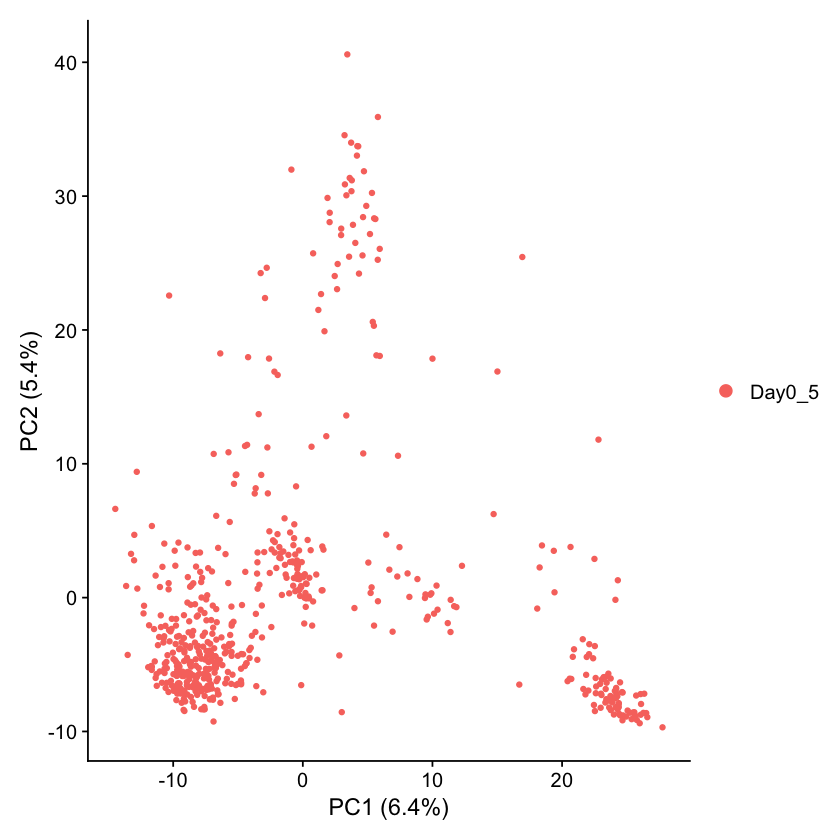

In [77]:
# To add the percent of variation explained by each component
pca_var <- Seurat::Stdev(object = day0_5_Seurat5, reduction = "pca")
pca_var_perc <- pca_var / sum(pca_var) * 100

pc1_perc <- round(pca_var_perc[1], 1)
pc2_perc <- round(pca_var_perc[2], 1)

PCA_plot1 = DimPlot(day0_5_Seurat5, reduction = "pca") +
                  xlab(paste0("PC1 (", round(pca_var_perc[1],1), "%)")) +
                  ylab(paste0("PC2 (", round(pca_var_perc[2],1), "%)"))
print(PCA_plot1)

In [66]:
pdf(file = "../Day0_5/figures/Day0_5_PCA.pdf",
    width = 10,
    height = 10)
print(PCA_plot1)
dev.off()

agg_record_96143414 
                  2

### Determine the dimensionality of the dataset

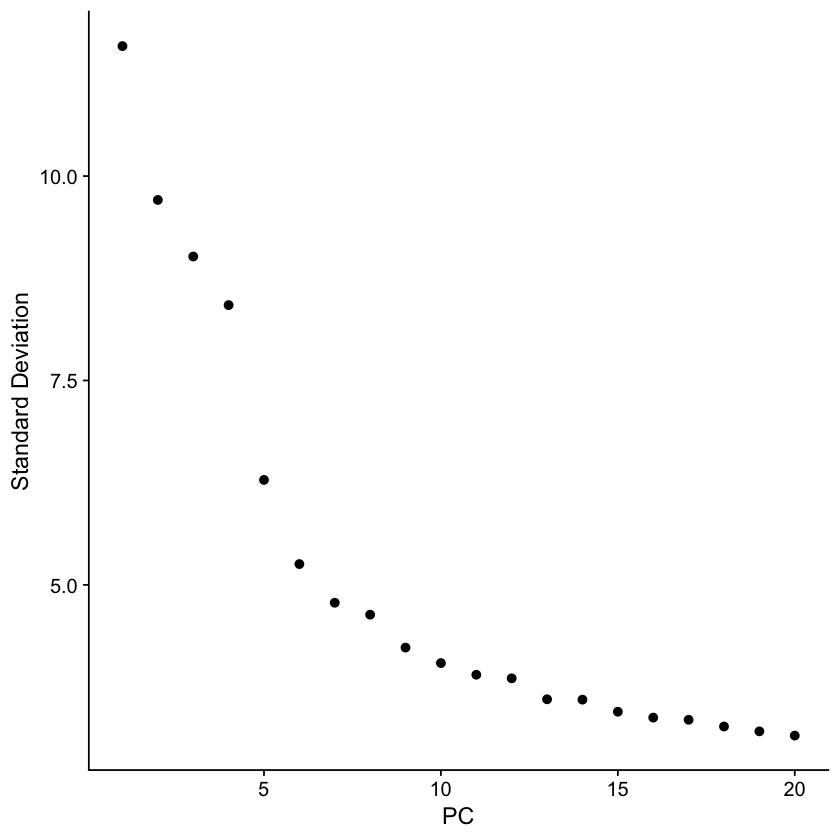

In [78]:
ElbowPlot(day0_5_Seurat5)

### Cluster the cells

In [79]:
# resolution
# Value of the resolution parameter, use a value above (below) 
# 1.0 if you want to obtain a larger (smaller) number of communities.
day0_5_Seurat5 = FindNeighbors(day0_5_Seurat5, dims = 1:50)
day0_5_Seurat5 = FindClusters(day0_5_Seurat5, resolution = c(0.2, 0.4, 0.6, 0.8, 1.0))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 583
Number of edges: 19346

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9253
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 583
Number of edges: 19346

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8758
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 583
Number of edges: 19346

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8366
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 583
Number of edges: 19346

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8060
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version

In [80]:
head(Idents(day0_5_Seurat5), 5)

AAACCCACAAGTACCT-1 AAACGCTCAAGTCCAT-1 AAAGAACAGTGAACAT-1 AAAGGATGTCACCCTT-1 
                 0                  1                  2                  1 
AAAGGGCGTATCCCTC-1 
                 5 
Levels: 0 1 2 3 4 5 6

### Run non-linear dimensional reduction, UMAP

In [81]:
day0_5_Seurat5 = RunUMAP(day0_5_Seurat5, dims = 1:50)

22:00:11 UMAP embedding parameters a = 0.9922 b = 1.112

22:00:11 Read 583 rows and found 50 numeric columns

22:00:11 Using Annoy for neighbor search, n_neighbors = 30

22:00:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:00:11 Writing NN index file to temp file /var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//RtmpDGYCod/file84c249f5a2c

22:00:11 Searching Annoy index using 1 thread, search_k = 3000

22:00:11 Annoy recall = 100%

22:00:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:00:11 Initializing from normalized Laplacian + noise (using RSpectra)

22:00:11 Commencing optimization for 500 epochs, with 22320 positive edges

22:00:11 Using rng type: pcg

22:00:12 Optimization finished



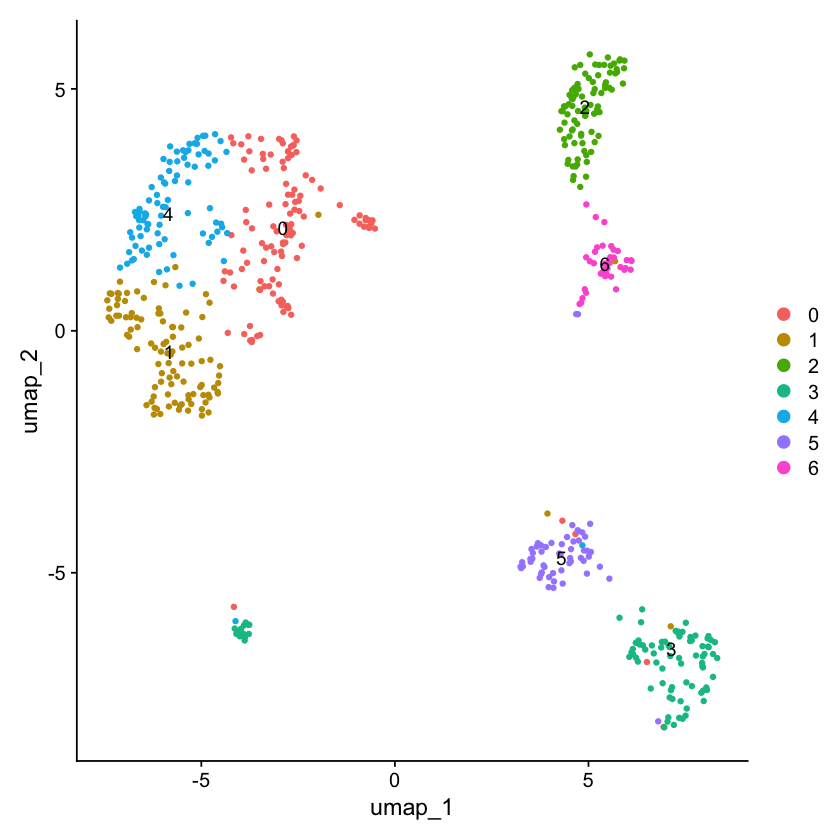

In [82]:
UMAP_plot1 = DimPlot(day0_5_Seurat5, reduction = "umap", label = TRUE)
print(UMAP_plot1)

In [83]:
pdf(file = "../Day0_5/figures/Day0_5_UMAP_plot.pdf",
    width = 10,
    height = 10)
print(UMAP_plot1)
dev.off()

agg_record_186953815 
                   2

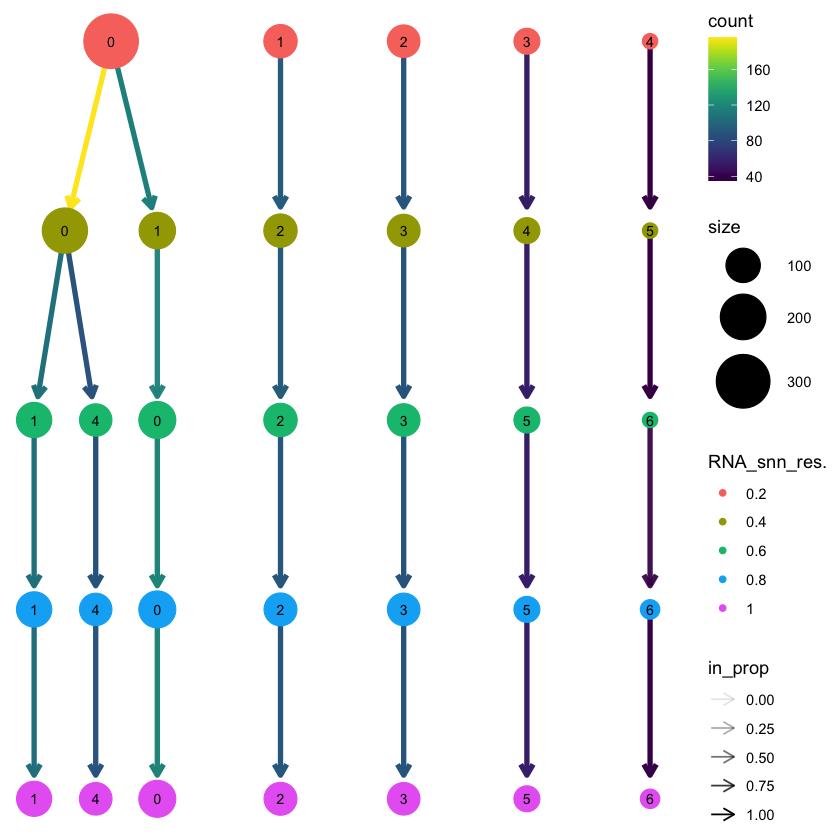

In [84]:
phylo_tree1 = clustree(day0_5_Seurat5, prefix = "RNA_snn_res.")
print(phylo_tree1)

In FindClusters(), resolution controls how finely the shared-nearest-neighbor (SNN) graph is cut:<br>
lower resolution → fewer, larger clusters<br>
higher resolution → more, smaller clusters<br>
Each column in clustree is a resolution. Each node is a cluster at that resolution.

In [85]:
pdf(file = "../Day0_5/figures/Day0_5_phylogenetic_tree.pdf",
    width = 10,
    height = 10)
print(phylo_tree1)
dev.off()

agg_record_27142893 
                  2

In [86]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Tahoe 26.0.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] future_1.68.0      clustree_0.5.1     ggraph_2.2.2       ggplot2_4.0.1     
[5] patchwork_1.3.2    Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
[9] dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.4        
  [4] spatstat.utils_3.2-0   farver_2.1.2           ragg_1.5.0            
  [7] vctrs_0.6.5            ROCR_1.0-11    